# Teste com a estação 14300000

In [ ]:
from modulos import eda, ann
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

2025-08-07 10:37:13.553445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754577433.564993 3572284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754577433.568471 3572284 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754577433.578715 3572284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754577433.578730 3572284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754577433.578731 3572284 computation_placer.cc:177] computation placer alr

In [2]:
dados = eda.data_processing('Cotas extraidas', '1985-01-01', '2023-12-31', ['dados_diarios_estacao_14300000.csv'])
dados

,14300000
Data,
1985-01-01,842.0
1985-01-02,822.0
1985-01-03,798.0
1985-01-04,751.0
1985-01-05,709.0
...,...
2023-12-27,553.0
2023-12-28,543.0
2023-12-29,678.0


### Separando o conjunto

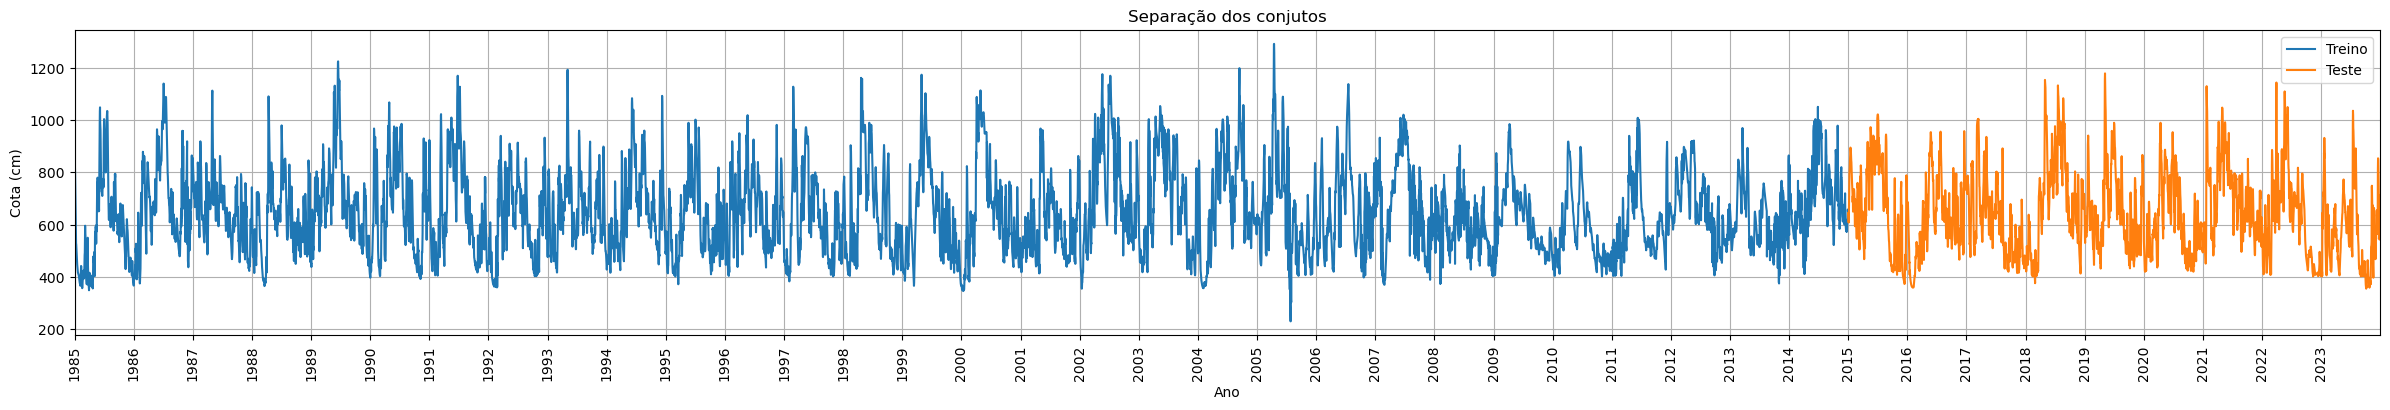

In [3]:
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

plt.figure(figsize=(24, 4))
plt.plot(treino)
plt.plot(teste)
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados.index[0], dados.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

In [4]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [5]:
janela = 30
steps = 15

X, y = create_multi_step_dataset(dados['14300000'].values, janela, steps)

x_train = X[:treino.shape[0]-janela]
y_train = y[:treino.shape[0]-janela]

x_test = X[treino.shape[0]-janela:]
y_test = y[treino.shape[0]-janela:]

x_scale = MinMaxScaler()
x_train = x_scale.fit_transform(x_train)
x_test = x_scale.transform(x_test)

y_scale = MinMaxScaler()
y_train = y_scale.fit_transform(y_train)

In [6]:
horizonte = [1, 7, 15]

### LSTM

In [21]:
lstm = ann.build_model_lstm(30, janela, steps)

lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,305 (16.82 KB)

 Trainable params: 4,305 (16.82 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
lstm.fit(x_train, y_train, epochs=100)

Epoch 1/100


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0523 - mean_absolute_error: 0.1692
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0933
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0135 - mean_absolute_error: 0.0905
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0878
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0126 - mean_absolute_error: 0.0859
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0851
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0832
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0843
Epoch 9/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - mean_absolute_error: 0.0829
Epoch 10/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0121 - mean_absolute_error: 0.0833
Epoch 11/100
342/342 ━━━━━━━━━━

In [23]:
pred = lstm.predict(x_test)
pred_inv = y_scale.inverse_transform(pred)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [24]:
r2_score(y_test, pred_inv)

0.4416836508398926

R²: 0.9306


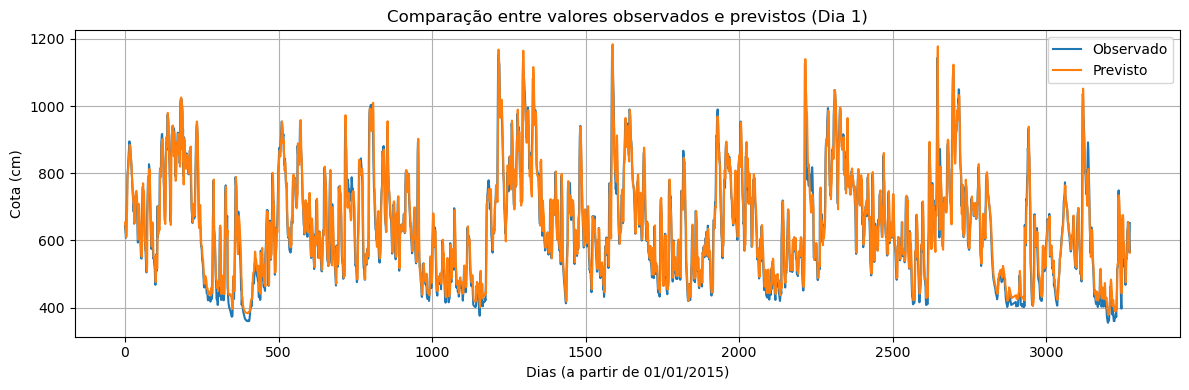

R²: 0.3886


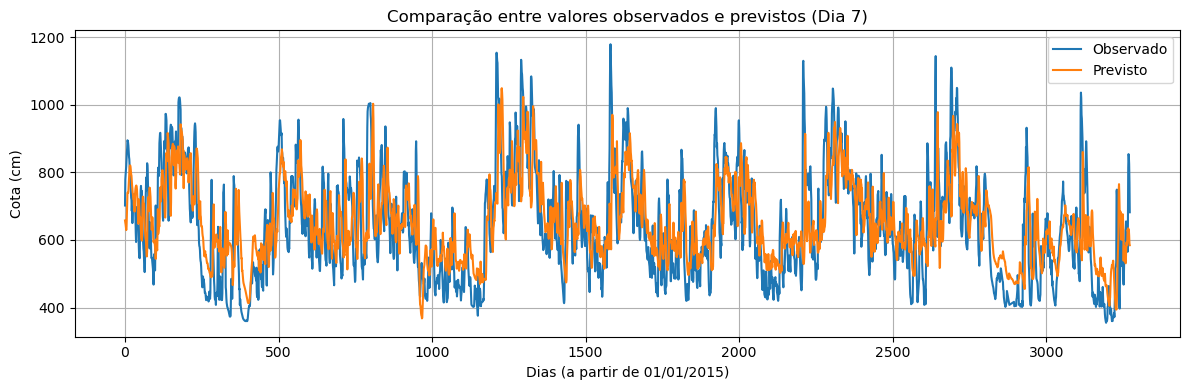

R²: 0.2338


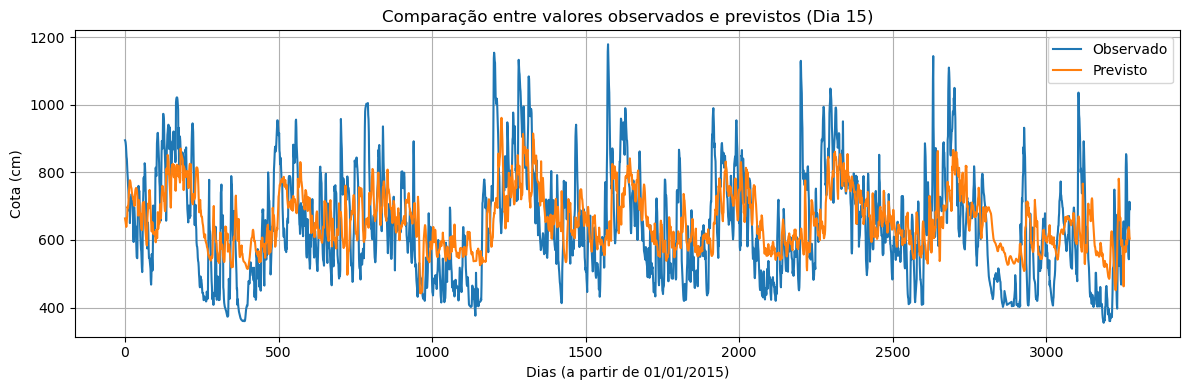

In [25]:
for i in horizonte:
    print(f"R²: {r2_score(y_test[:,i-1], pred_inv[:,i-1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test[:,i-1], label='Observado')
    plt.plot(pred_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (cm)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### MLP

In [26]:
mlp = ann.build_model_mlp((30, 30), janela, steps)

mlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │           465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
mlp.fit(x_train, y_train, epochs=100)

Epoch 1/100


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0641 - mean_absolute_error: 0.1760
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0132 - mean_absolute_error: 0.0888
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0125 - mean_absolute_error: 0.0856
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0124 - mean_absolute_error: 0.0852
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0124 - mean_absolute_error: 0.0848
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0123 - mean_absolute_error: 0.0851
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0120 - mean_absolute_error: 0.0834
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.0121 - mean_absolute_error: 0.0838
Epoch 9/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0120 - mean_absolute_error: 0.0831
Epoch 10/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0118 - mean_absolute_error: 0.0826
Epoch 11/100


In [28]:
pred2 = mlp.predict(x_test)
pred2_inv = y_scale.inverse_transform(pred2)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [29]:
r2_score(y_test, pred2_inv)

0.46836164732839286

R²: 0.9343


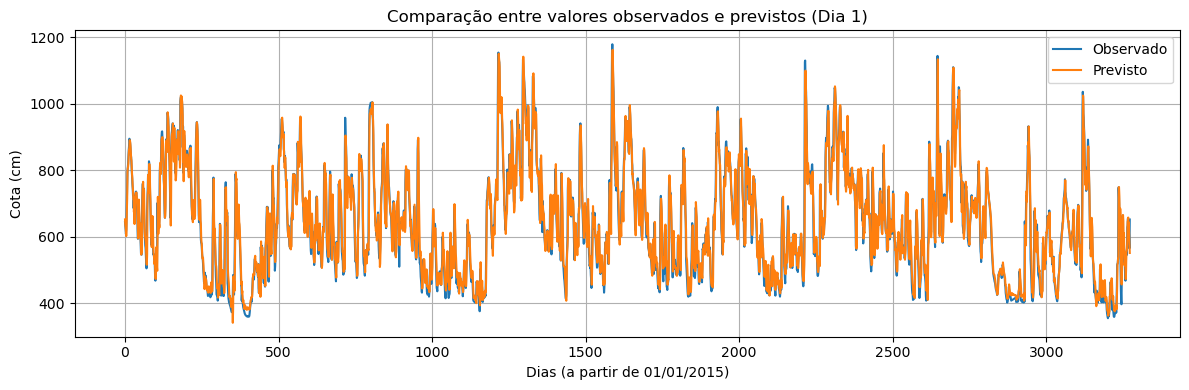

R²: 0.4258


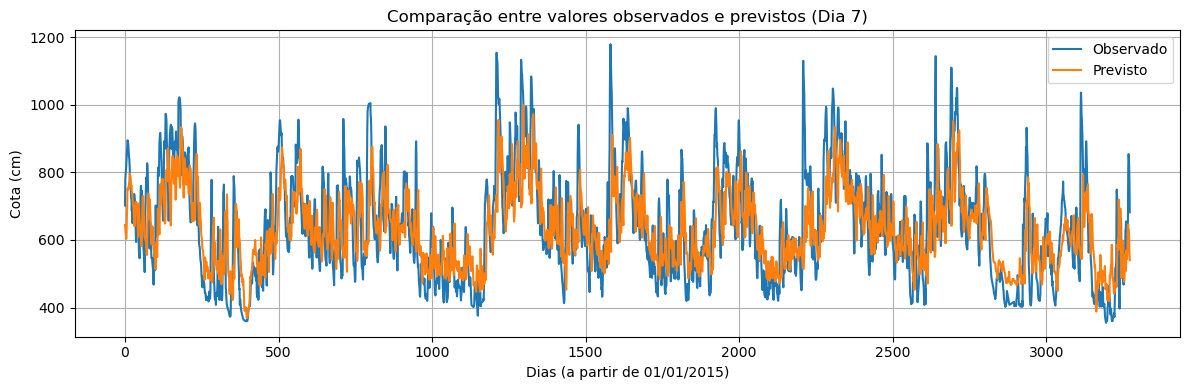

R²: 0.2630


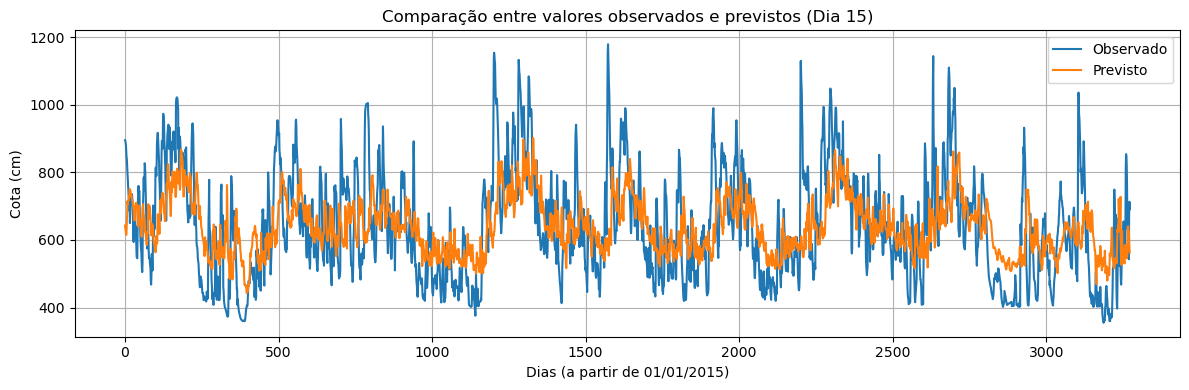

In [30]:
for i in horizonte:
    print(f"R²: {r2_score(y_test[:,i-1], pred2_inv[:,i-1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test[:,i-1], label='Observado')
    plt.plot(pred2_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (cm)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### XGBoost

In [17]:
xgbs = []

for i in range(steps):
    model = XGBRegressor()

    model.fit(x_train, y_train[:, i])
    xgbs.append(model)

In [18]:
Y_pred = np.zeros_like(y_test)

for i, model in enumerate(xgbs):
    pred = model.predict(x_test)
    Y_pred[:, i] = pred

Y_pred = y_scale.inverse_transform(Y_pred)

In [19]:
r2_score(y_test, Y_pred)

0.3790318621798475

R²: 0.9307


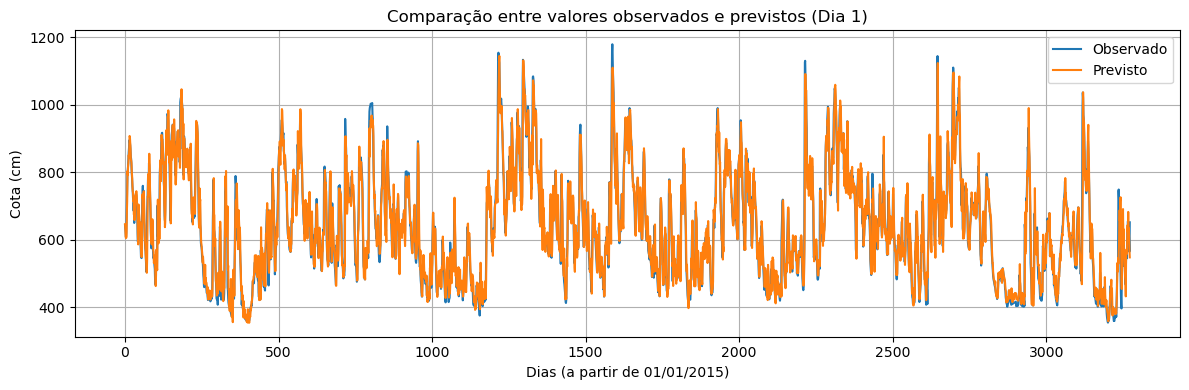

R²: 0.3374


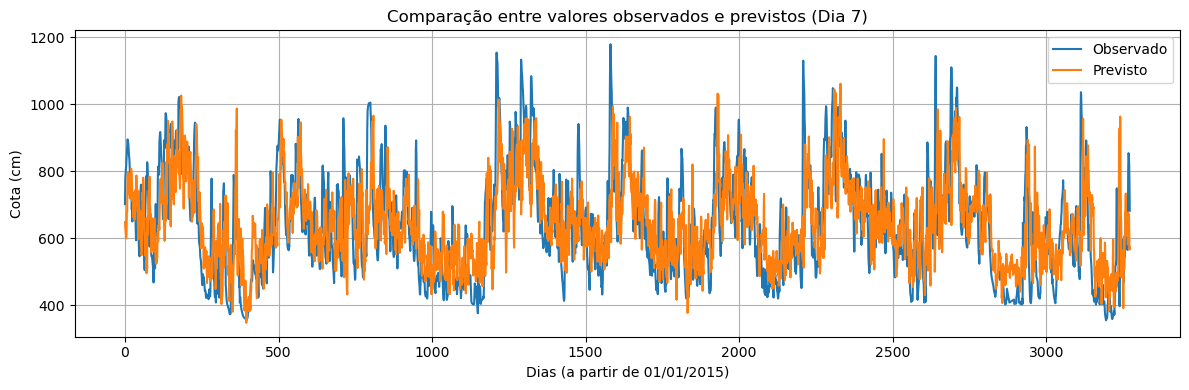

R²: 0.1211


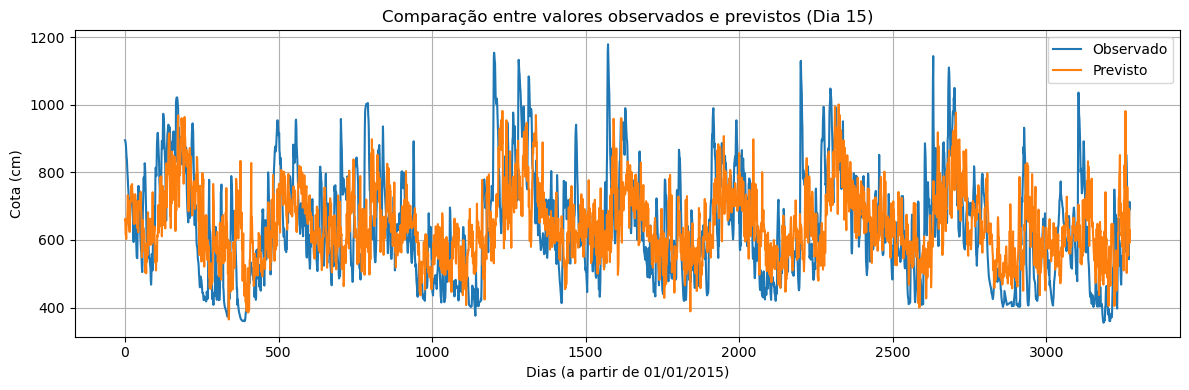

In [20]:
for i in horizonte:
    print(f"R²: {r2_score(y_test[:,i-1], Y_pred[:,i-1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test[:,i-1], label='Observado')
    plt.plot(Y_pred[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (cm)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()